# Walkthrough of IB Color Naming Model

This notebook contains a walkthrough of an implementation of the color naming model from Zaslavsky, Kemp, Regier and Tishby (2018) in ULTK.

This involves several simplifying assumptions. If you want to apply the actual naming model from the paper, you should add https://github.com/nogazs/ib-color-naming/tree/master as a submodule to your project.

Imports

In [1]:
import numpy as np

from ultk.effcomm import ib
from ultk.language.semantics import Universe

## Construct the IB model

### Load the universe

In [2]:
# This assumes you've run the script ./scripts/read_color_universe.py
color_universe = Universe.from_csv("outputs/color_universe.csv")

# shape `(330, 3)`: L*a*b* values for each Munsell chip
cielab_points = np.array([(ref.L, ref.a, ref.b) for ref in color_universe.referents])

### Define meaning distributions in terms of distance in CIELAB space

In [3]:
def meaning_distance(
    center: np.ndarray, other_point: np.ndarray, sigma_squared: float = 64.0
) -> float:
    """Calculate the distance between two points in CIELAB space.

    Args:
        center: the first point (e.g. (L, a, b) for a Munsell chip)
        other_point: the second point
        sigma_squared: the variance of the Gaussian kernel

    Returns:
        exp(-||center - other_point||^2 / (2 * sigma_squared))
    """
    return np.exp(np.linalg.norm(center - other_point) ** 2 / (2 * sigma_squared))

# shape: `(330, 330)`
meaning_distributions = np.array(
    [
        [meaning_distance(center, other_point) for other_point in cielab_points]
        for center in cielab_points
    ]
)
meaning_distributions /= meaning_distributions.sum(axis=1, keepdims=True)

In [4]:
pU_M = meaning_distributions

Assume a uniform prior

In [5]:
pM = np.full(pU_M.shape[0], 1/pU_M.shape[0])

### Get IB model

In [8]:
# This take horribly long, after 20m only 60% through
model = ib.get_ib_naming_model(
    pU_M,
    pM,
    # add custom beta values here
    betas=np.logspace(0, 10, 30,)
)

beta=1.00000: 100%|██████████| 30/30 [1:53:03<00:00, 226.13s/it]      


## Load natural languages

In [10]:
import pandas as pd
from ultk.language.language import Language
from yaml import load, Loader

In [ ]:
# Takes a minute
with open("./outputs/natural_languages.yaml", "r") as f:
    languages = load(f, Loader=Loader)

Define the mapping from Language to IB encoder

In [11]:

def language_to_encoder(language: Language) -> np.ndarray:
    """Convert a Language to an IB encoder, q(w|m).

    Args:
        language: the lexicon from which to infer a speaker (encoder).
        It is assumed that each `Expression` in the `Language` has a `Meaning` that maps to floats.

    Returns:
        a numpy array of shape `(|referents|, |words|)`
        where element (r, w) is the probability of word w given referent r
    """
    # (|referents|, |words|): p(r | w)
    pW_M = np.array(
        [
            [expression.meaning[referent] for expression in language.expressions]
            for referent in language.universe.referents
        ]
    )
    return pW_M

In [15]:
langq = lambda lang: language_to_encoder(lang)
get_point = lambda q: (model.complexity(q), model.accuracy(q), model.d_IB(q))

df_langs = pd.DataFrame.from_records(
    [
        (lang.name,)
        + get_point(langq(lang))
        for lang in languages
    ],
    columns=("language", "complexity", "accuracy", "distortion"),
)

## Plot

In [16]:
import plotnine as pn

In [17]:
df_bound = pd.DataFrame()
df_bound["complexity"] = model.IB_curve[0]
df_bound["accuracy"] = model.IB_curve[1]
# add beta column if you like

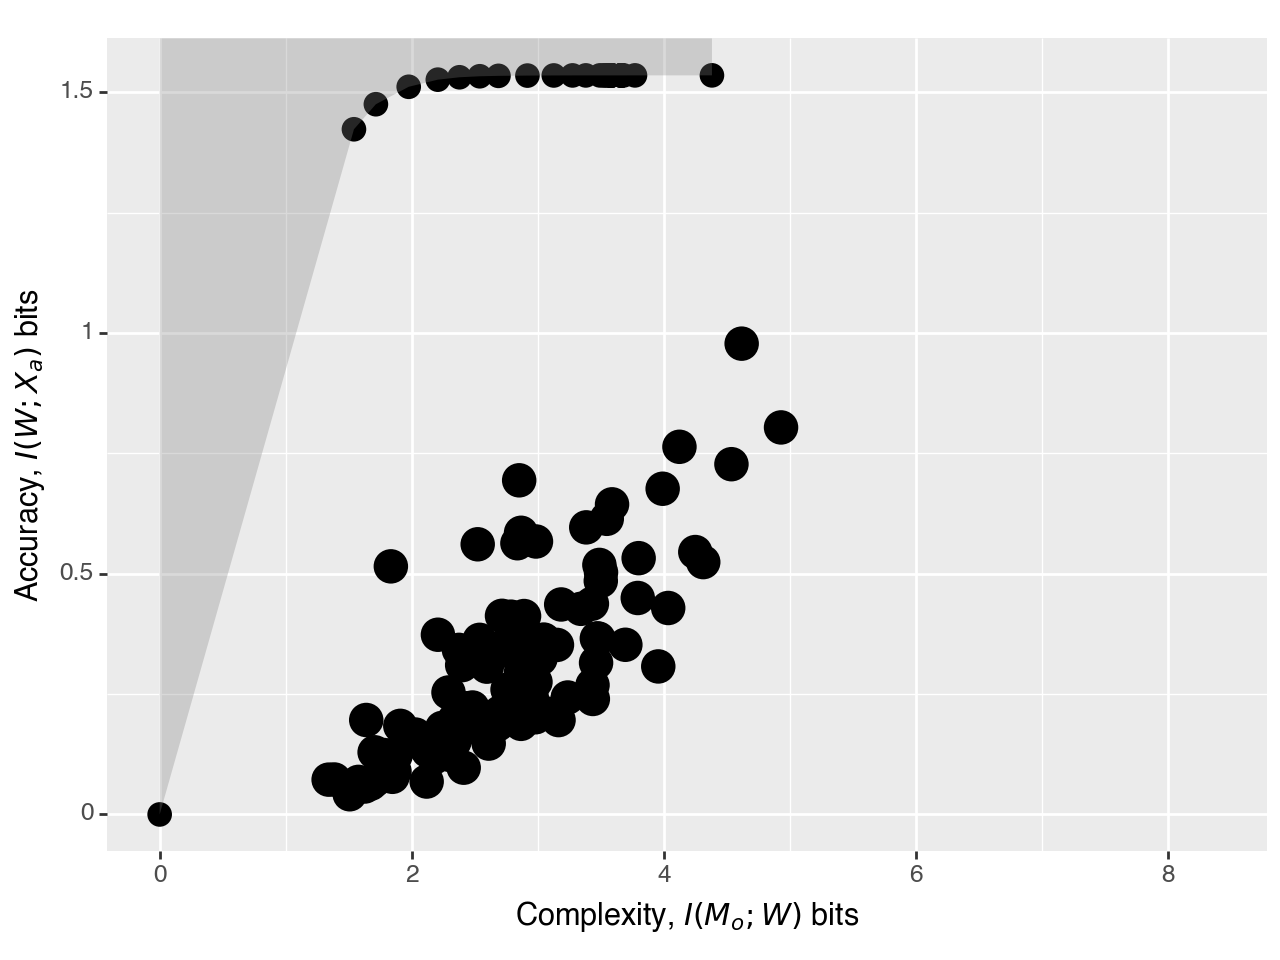

<Figure Size: (640 x 480)>

In [ ]:
(
    pn.ggplot(
        df_bound, 
        mapping=pn.aes(x="complexity", y="accuracy"),
    )  
    + pn.geom_line(size=4) # IB curve
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=np.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    # natural langs
    + pn.geom_point( 
        data=df_langs,
        # alpha=0.3,
        size=6,
    )
    + pn.xlim([0,np.log2(pM.shape[0])])
    + pn.xlab("Complexity, $I(M_o;W)$ bits")
    + pn.ylab("Accuracy, $I(W;X_a)$ bits")
)